# Exo 1: Imaging Inverse Problems with Explicit Regularization

<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2425/tp5_exo1_inverse_problem_with_explicit_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

In this practical session, you have to complete the code regions marked ``### ... ###``.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# # default directory:
# %cd /content/drive/MyDrive/Colab\ Notebooks
# # we advise to create a specific directory on your Google drive:
# %cd /content/drive/MyDrive/genmod

In [6]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename=False):
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(u0.shape)>2 else None
    imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))


# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
!unzip tpdeblur.zip

2.9.0+cu126
--2026-02-10 10:14:56--  https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774047 (756K) [application/zip]
Saving to: ‘tpdeblur.zip.2’

tpdeblur.zip.2      100%[===================>] 755.91K   801KB/s    in 0.9s    

2026-02-10 10:14:58 (801 KB/s) - ‘tpdeblur.zip.2’ saved [774047/774047]

Archive:  tpdeblur.zip
replace im/simpson512crop.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: yA
  inflating: im/simpson512crop.png   
replace im/simpson512.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: im/simpson512.png       
  inflating: im/room.png             
  inflating: im/tshirt.png           
  inflating: kernels/kernel_0.png    
  inflating: kernels/kernel_1.png    
  inflating: kernels/kernel

# A) Deblurring with Tychonov and $\mathsf{TV}_\varepsilon$ regularizations

<br/>In this practical session, you have to fill the code at places marked ``### ... ###``

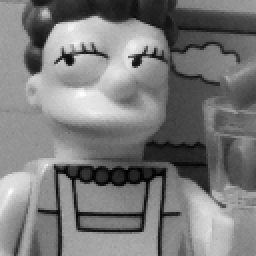

In [7]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

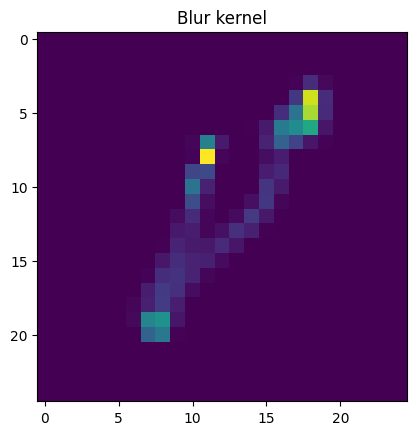

In [8]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
fk = fft2(k)

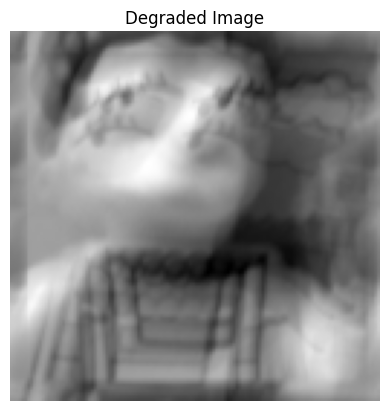

In [14]:
# Compute the degraded image ublur = k*u0 + w  (convolution with periodic boundary conditions)
sigma = 0.02
ublur = fft2(u0)*fk + sigma*torch.randn(M,N)
ublur = torch.real(ifft2(ublur))

plt.figure(dpi=100)
plt.imshow(ublur,cmap='gray')
plt.title('Degraded Image')
plt.axis('off')
plt.show()

## Deblurring with Tychonov regularization

Tychonov deblurring $u_{tych}$ is obtained as the minimal point of the following functional
$$ F_{\lambda}(u) = \frac{1}{2} \|k*u - u_{\text{blur}}\|_2^2 + \frac{\lambda}{2} \|\nabla u\|_2^2 $$
where the squared gradient norm is
$$ \|\nabla u\|_2^2 = \|\partial_1 u\|_2^2 + \|\partial_2 u\|_2^2 = \sum_{(x,y) \in \Omega} \partial_1 u(x,y)^2 + \partial_2 u(x,y)^2 .$$
The parameter $\lambda > 0$ allows to give more or less weight to the regularization.

For the derivatives $\partial_1 u, \partial_2 u$, you can use a simple discrete scheme, computed with periodic boundary conditions.

In [ ]:
# Write the functional with data-fidelity and regularization with weight lambda (called lam below)
# Remark: For convenience, lam can be passed to F as a global variable (however, notice that it is not the best practice).

def F(u):
  return 0.5 * torch.sum(torch.real(fk*fft2(u)) - ublur, dim=-1)**2 + lam * 0.5 * torch.norm(u.grad, p=2)


lam = 0.01
tau = ### ... ###

# Perform gradient descent (with fixed step size) in order to approximate the solution
# Outputs should be
#     u         (restored image)
#     losslist  (list of values of cost function along the iterations)
#
# You use the wrapper optim(f, ...) given in the preamble.

### ... ###


utych = u  # (save results for further comparisons)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(ublur, cmap='gray')
plt.title('Blurred \n PSNR='+str2(psnr(u0,ublur)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=100)
plt.plot(losslist)
plt.show()

Tychonov deblurring can also be computed with filtering, directly in the Fourier domain:

$$ \forall (\xi,\zeta) \in \Omega, \quad
    \widehat{u_{\text{tych}}}(\xi,\zeta) = \frac{\overline{\widehat{k}(\xi,\zeta)} }{|\widehat{k}(\xi,\zeta)|^2 + \lambda \ \hat{L}(\xi,\zeta) } \ \widehat{u_{\text{blur}}}(\xi,\zeta) $$
where

$$\hat{L}(\xi,\zeta) = 4  \left( \sin^2 \left(\frac{\pi \xi}{M} \right) +  \sin^2 \left(\frac{\pi \zeta}{N} \right) \right) .$$

In [ ]:
# Implement here the explicit computation of Tychonov deblurring

# You may use the following lines that generate arrays
# of normalized frequencies (xi, zeta) in [-M/2,M/2]x[-N/2,N/2]
xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')


us = ### ... ###

print('Final error = ',torch.max(torch.abs((utych-us))))


## Deblurring with smoothed total variation

In the course session, we have defined the smoothed total variation as
$$ \mathsf{TV}_{\varepsilon}(u)
= \sum_{(x,y) \in \Omega} \sqrt{ \varepsilon^2 + \partial_1 u (x,y)^2 + \partial_2 u (x,y)^2 } \ .$$
where $\varepsilon > 0$ is a parameter.

$\mathsf{TV}_{\varepsilon}$-deblurring is obtained as the minimal point of the following functional
$$ G_{\lambda}(u) = \frac{1}{2} \|k*u - u_{\text{blur}}\|_2^2 + \lambda \mathsf{TV}_{\varepsilon}(u) $$

In [ ]:
# Write the functional with data-fidelity and regularization with weight lambda (called lam below)
def G(u):
    ### ... ###


lam = 0.01
tau = ### ... ###

# Perform gradient descent (with fixed step size) in order to approximate the solution
# Outputs should be
#     u         (restored image)
#     losslist  (list of values of cost function along the iterations)
#
# You use the wrapper optim(f, ...) given in the preamble.

### ... ###

utvs = u  # (save results for further comparisons)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(ublur, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(utvs, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

In [ ]:
# Compare deblurring results with Tychonov regularization and TV_ep regularization

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ublur, cmap='gray')
plt.title('Blurred',fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,utych)),fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(utvs, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,utvs)),fontsize=8)
plt.axis('off')
plt.show()

## Adjusting the regularization parameter (at home)

In [ ]:
# Find the value of the regularization parameter lambda that optimizes the PSNR
# Do it first for Tychonov regularization, and then for smoothed TV.
# Compare the final restoration results obtained with these oracle values of lambda.

### ... ###

<br/><br/><br/><br/><br/>

# B) Inpainting with $\mathsf{TV}_{\varepsilon}$ regularization (at home)

In [ ]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

In [ ]:
# Generate a random mask with proportion p of masked pixels
p = .9
mask = (torch.rand(M,N)<p)*1.
# other choice:
#mask = torch.ones(M,N)
#mask[:,60:65] = 0

umask = u0*mask

viewimage(umask)

## Relaxed Inpainting


In order to perform $\mathsf{TV}_{\varepsilon}$, you have to minimize the following functional

$$ F_\lambda(u) = \frac{1}{2} \| (u- u_{\text{mask}}) \cdot \text{mask} \|_2^2 + \lambda \mathsf{TV}_{\varepsilon}(u) . $$


In [ ]:
# Perform relaxed TV inpainting

### ... ###

## Constrained Inpainting (with Projected Gradient Descent)

Instead of doing gradient descent on $F_\lambda$, you will perform projected gradient descent to minimize $\mathsf{TV}_\epsilon$ under the constraint $(u- u_{\text{mask}}) \cdot \text{mask} = 0$:
$$ u_{k+1} = p\Big(u_k - \tau \nabla \mathsf{TV}_\epsilon(u_k) \Big) ,$$
where $p$ is the projection on the constraint, that is, $p$ reimposes the known values where $\textrm{mask}=0$.

In [ ]:
# Perform constrained TV inpainting by minimizing tv_ep(u) with constraint u = umask outside the mask

### ... ###

<br/><br/><br/><br/><br/>